# 🚀 Modelado TIER 1: XGBoost

> **Objetivo**: Entrenar y evaluar un modelo XGBoost para predecir **nombres de fertilizantes** basado en condiciones de suelo y cultivo.
> 
> **Variable Objetivo**: `Fertilizer Name` (nombres de fertilizantes codificados)
> 
> **Estrategia**: Usar XGBoost como modelo avanzado de gradient boosting debido a su alta precisión, eficiencia computacional y excelente rendimiento en competencias de machine learning para problemas de clasificación multiclase.
> 
> **Métrica Principal**: MAP@3 (Mean Average Precision at 3) - requerida por la competencia de Kaggle

---

## 📚 1. Carga de Librerías y Datos

### Importación de librerías necesarias y carga de datos preprocesados

In [1]:
# Librerías principales
import pandas as pd
import numpy as np
import pickle
import joblib

# Utilidades del proyecto
import sys
sys.path.append('../src')
from model_utils import ModelTrainer, print_feature_selection_summary, print_training_config, show_prediction_examples
from visuals import plot_confusion_matrix, plot_probability_analysis, plot_predictions_vs_actual, plot_top3_accuracy_analysis, plot_feature_importance
from metrics import mapk

# XGBoost
import xgboost as xgb

In [2]:
# Inicializar trainer y cargar datos
trainer = ModelTrainer('XGBClassifier', 'XGB')
data = trainer.load_data()

# Extraer datasets
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test = data['X_test']
feature_info = data['feature_info']
label_encoders = data['label_encoders']
fertilizer_encoder = label_encoders['Fertilizer Name']

print("Datos cargados exitosamente:")
print(f"  • Variable objetivo: {y_train.name}")

📂 Cargando datos preprocesados...
✅ Datos cargados: Train(600000, 32), Val(150000, 32), Test(250000, 32)
Datos cargados exitosamente:
  • Variable objetivo: Fertilizer Name_encoded


## 🎯 2. Selección de Features

### Definiendo las características que utilizaremos para el modelo

In [3]:
# =============================================================================
# SELECCIÓN DE FEATURES PARA EL MODELO
# =============================================================================

features_to_use = [
    # 🌡️ VARIABLES CLIMÁTICAS ORIGINALES
    'Temparature',
    'Humidity', 
    'Moisture',
    
    # 🌱 VARIABLES DE SUELO Y CULTIVO
    # 'Soil Type',
    # 'Crop Type',
    
    # 🧪 VARIABLES QUÍMICAS (NPK)
    'Nitrogen',
    'Potassium', 
    'Phosphorous',
    
    # # 📊 FEATURES ENGINEERED - RATIOS NPK
    'N_P_ratio',
    'N_K_ratio',
    'P_K_ratio',
    'Total_NPK',
    
    # # 🌡️ FEATURES ENGINEERED - ÍNDICES CLIMÁTICOS
    'Temp_Hum_index',
    'Moist_Balance',
    'Environ_Stress',
    
    # # 🏷️ FEATURES ENGINEERED - CATEGORÍAS
    # 'Temp_Cat',
    # 'Hum_Cat',
    # 'N_Level',
    # 'K_Level',
    # 'P_Level',
    
    # # 🔗 FEATURES ENGINEERED - COMBINACIONES
    # 'Soil_Crop_Combo',
    'NPK_Balance',
    'Dominant_NPK_Level',
    'Temp_Moist_inter',
    
    # # 🔢 FEATURES ENCODED (CATEGÓRICAS)
    'Soil Type_encoded',
    'Crop Type_encoded',
    'Temp_Cat_encoded',
    'Hum_Cat_encoded',
    'N_Level_encoded',
    'K_Level_encoded',
    'P_Level_encoded',
    'Soil_Crop_Combo_encoded'
]

# Validar features disponibles
features_to_use = trainer.validate_features(features_to_use, X_train)
print_feature_selection_summary(features_to_use, features_to_use)

✅ Features válidas: 24
🎯 FEATURES SELECCIONADAS: 24
   1. Temparature
   2. Humidity
   3. Moisture
   4. Nitrogen
   5. Potassium
   6. Phosphorous
   7. N_P_ratio
   8. N_K_ratio
   9. P_K_ratio
  10. Total_NPK
  11. Temp_Hum_index
  12. Moist_Balance
  13. Environ_Stress
  14. NPK_Balance
  15. Dominant_NPK_Level
  16. Temp_Moist_inter
  17. Soil Type_encoded
  18. Crop Type_encoded
  19. Temp_Cat_encoded
  20. Hum_Cat_encoded
  21. N_Level_encoded
  22. K_Level_encoded
  23. P_Level_encoded
  24. Soil_Crop_Combo_encoded


## ⚙️ 3. Configuración de Hiperparámetros

### Definiendo los parámetros del modelo XGBoost

In [4]:
# =============================================================================
# CONFIGURACIÓN DE HIPERPARÁMETROS - OPTIMIZADA PARA 750K DATOS
# =============================================================================

# 🎯 BASELINE CONSERVADORA (RÁPIDA)
xgb_params_baseline = {
    "objective": "multi:softprob",
    "num_class": len(fertilizer_encoder.classes_),
    "eval_metric": "mlogloss",
    "booster": "gbtree",
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "colsample_bylevel": 1.0,
    "colsample_bynode": 1.0,
    "min_child_weight": 1,
    "gamma": 0,
    "reg_alpha": 0,
    "reg_lambda": 1,
    "scale_pos_weight": 1,
    "random_state": 513,
    "n_jobs": -1,
    "verbosity": 0,
    "tree_method": "auto"
}

# 🚀 CONFIGURACIÓN OPTIMIZADA (PARA SUPERAR MAP@3=0.3278)
xgb_params_optimized = {
    "objective": "multi:softprob",
    "num_class": len(fertilizer_encoder.classes_),
    "eval_metric": "mlogloss",
    "booster": "gbtree",
    "n_estimators": 500,      # ⬆️ Incrementado de 300 a 500 para mejor convergencia
    "max_depth": 10,          # ⬆️ Aumentado de 8 a 10 para capturar más complejidad
    "learning_rate": 0.04,    # ⬇️ Ligeramente reducido de 0.05 para mejor estabilidad
    "subsample": 0.88,        # ⬆️ Incrementado de 0.85 para usar más datos por árbol
    "colsample_bytree": 0.92, # ⬆️ Incrementado para mayor diversidad de features
    "colsample_bylevel": 0.85,# ⬇️ Reducido para mayor diversidad por nivel
    "colsample_bynode": 0.85, # ⬇️ Reducido para evitar overfitting
    "min_child_weight": 2,    # ⬇️ Reducido de 3 a 2 para permitir hojas más específicas
    "gamma": 0.05,            # ⬇️ Reducido de 0.1 para menos regularización
    "reg_alpha": 0.005,       # ⬇️ Reducido para menos regularización L1
    "reg_lambda": 1.2,        # ⬇️ Reducido de 1.5 para balance en regularización L2
    "scale_pos_weight": 1,
    "random_state": 513,
    "n_jobs": -1,
    "verbosity": 0,
    "tree_method": "hist"     # ⬆️ Más eficiente para dataset grande
}

# 🔥 CONFIGURACIÓN AGRESIVA PERO EFICIENTE (MEMORY-FRIENDLY)
xgb_params_ultra = {
    "objective": "multi:softprob",
    "num_class": len(fertilizer_encoder.classes_),
    "eval_metric": "mlogloss",
    "booster": "gbtree",
    "n_estimators": 450,      # ⬇️ Reducido de 700 a 450 para eficiencia de memoria
    "max_depth": 9,           # ⬇️ Reducido de 12 a 9 para controlar memoria
    "learning_rate": 0.045,   # ⬆️ Ligeramente mayor por menos estimadores
    "subsample": 0.9,         # ⬆️ Usar 90% de los datos por árbol
    "colsample_bytree": 0.95, # ⬆️ Usar casi todas las features
    "colsample_bylevel": 0.8, # Balance en diversidad por nivel
    "colsample_bynode": 0.8,  # Balance en diversidad por nodo
    "min_child_weight": 1.5,  # ⬇️ Permitir hojas más específicas
    "gamma": 0.03,            # ⬇️ Regularización mínima
    "reg_alpha": 0.003,       # ⬇️ Regularización L1 mínima
    "reg_lambda": 0.9,        # ⬆️ Ligeramente mayor que antes
    "scale_pos_weight": 1,
    "random_state": 513,
    "n_jobs": -1,
    "verbosity": 0,
    "tree_method": "hist"     # ⬆️ Método más eficiente en memoria
}

# Seleccionar configuración según contexto
print("📊 CONFIGURACIONES DISPONIBLES:")
print("\n🎯 1. BASELINE (Rápida - ~2 min):")
print(f"   • n_estimators: {xgb_params_baseline['n_estimators']}")
print(f"   • max_depth: {xgb_params_baseline['max_depth']}")
print(f"   • learning_rate: {xgb_params_baseline['learning_rate']}")

print("\n🚀 2. OPTIMIZADA (Para superar 0.3278 - ~12 min):")
print(f"   • n_estimators: {xgb_params_optimized['n_estimators']}")
print(f"   • max_depth: {xgb_params_optimized['max_depth']}")
print(f"   • learning_rate: {xgb_params_optimized['learning_rate']}")

print("\n🔥 3. AGRESIVA EFICIENTE (Memory-friendly - ~15 min):")
print(f"   • n_estimators: {xgb_params_ultra['n_estimators']}")
print(f"   • max_depth: {xgb_params_ultra['max_depth']}")
print(f"   • learning_rate: {xgb_params_ultra['learning_rate']}")

# Decidir qué configuración usar
USE_OPTIMIZED = True   # True para configuración optimizada
USE_ULTRA = False      # True para configuración agresiva eficiente

if USE_ULTRA:
    xgb_params = xgb_params_ultra
    print("\n🔥 Usando CONFIGURACIÓN AGRESIVA EFICIENTE")
    print("   📈 Objetivo: Alto MAP@3 con uso eficiente de memoria")
elif USE_OPTIMIZED:
    xgb_params = xgb_params_optimized
    print("\n🚀 Usando CONFIGURACIÓN OPTIMIZADA")
    print("   📈 Objetivo: Superar MAP@3=0.3278")
else:
    xgb_params = xgb_params_baseline
    print("\n⚡ Usando CONFIGURACIÓN BASELINE")
    print("   🎯 Objetivo: Validación rápida")

print_training_config(xgb_params)

📊 CONFIGURACIONES DISPONIBLES:

🎯 1. BASELINE (Rápida - ~2 min):
   • n_estimators: 100
   • max_depth: 6
   • learning_rate: 0.1

🚀 2. OPTIMIZADA (Para superar 0.3278 - ~12 min):
   • n_estimators: 500
   • max_depth: 10
   • learning_rate: 0.04

🔥 3. AGRESIVA EFICIENTE (Memory-friendly - ~15 min):
   • n_estimators: 450
   • max_depth: 9
   • learning_rate: 0.045

🚀 Usando CONFIGURACIÓN OPTIMIZADA
   📈 Objetivo: Superar MAP@3=0.3278
⚙️ CONFIGURACIÓN:
  • objective: multi:softprob
  • num_class: 7
  • eval_metric: mlogloss
  • booster: gbtree
  • n_estimators: 500
  • max_depth: 10
  • learning_rate: 0.04
  • subsample: 0.88
  • colsample_bytree: 0.92
  • colsample_bylevel: 0.85
  • colsample_bynode: 0.85
  • min_child_weight: 2
  • gamma: 0.05
  • reg_alpha: 0.005
  • reg_lambda: 1.2
  • scale_pos_weight: 1
  • random_state: 513
  • n_jobs: -1
  • verbosity: 0
  • tree_method: hist


## 🚀 4. Entrenamiento del Modelo

### Inicialización y entrenamiento del XGBoost

In [5]:
# =============================================================================
# ENTRENAMIENTO DEL MODELO
# =============================================================================

# Inicializar y entrenar modelo
xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model = trainer.train_model(xgb_model, X_train, y_train, features_to_use)

🚀 Entrenando XGBClassifier...
✅ Entrenamiento completado en 875.66s


## 📊 5. Evaluación del Modelo

### Evaluación del rendimiento en el conjunto de validación

In [6]:
# =============================================================================
# EVALUACIÓN DEL MODELO
# =============================================================================

# Evaluar modelo
metrics = trainer.evaluate_model(X_val, y_val, features_to_use)

# Generar predicciones para visualizaciones
y_pred_val = xgb_model.predict(X_val[features_to_use])
y_pred_proba_val = xgb_model.predict_proba(X_val[features_to_use])
classes = xgb_model.classes_
y_pred_top3 = trainer.get_top3_predictions(y_pred_proba_val, classes)

# Mostrar ejemplos de predicciones
# show_prediction_examples(y_val, y_pred_top3, fertilizer_encoder, num_examples=3)

# Variables para visualizaciones
map3_score = metrics['map3_score']
auc_roc = metrics['auc_roc']
accuracy = metrics['accuracy']
precision = metrics['precision']
recall = metrics['recall']
f1 = metrics['f1_score']

📊 Evaluando modelo...
🎯 MAP@3: 0.3254 | AUC-ROC: 0.5654 | Accuracy: 0.1913


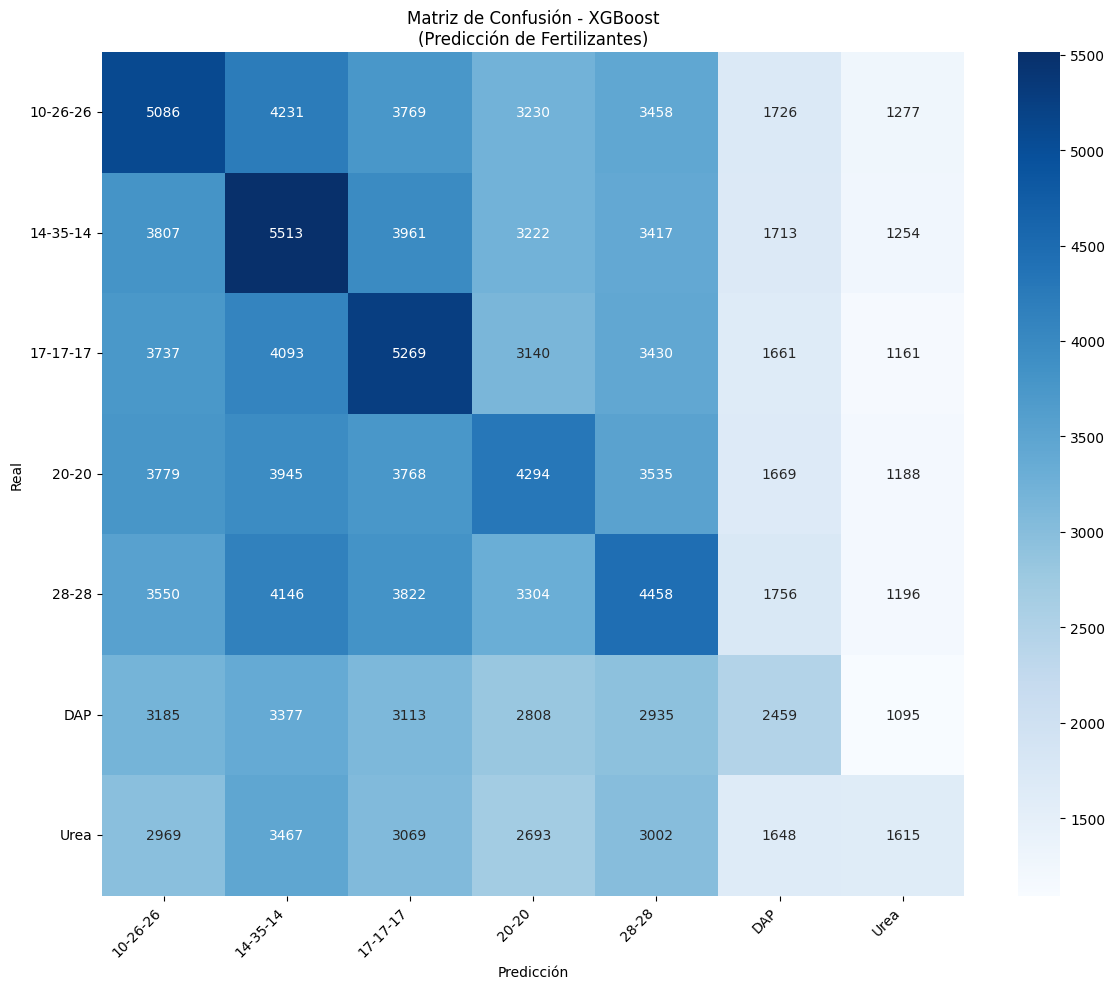

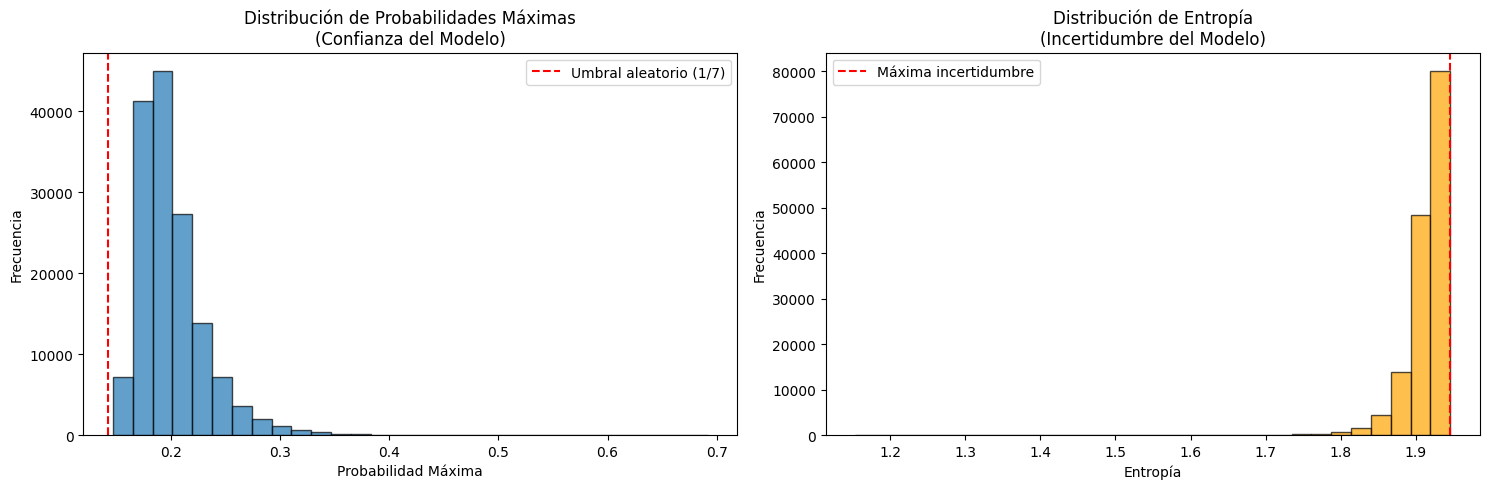

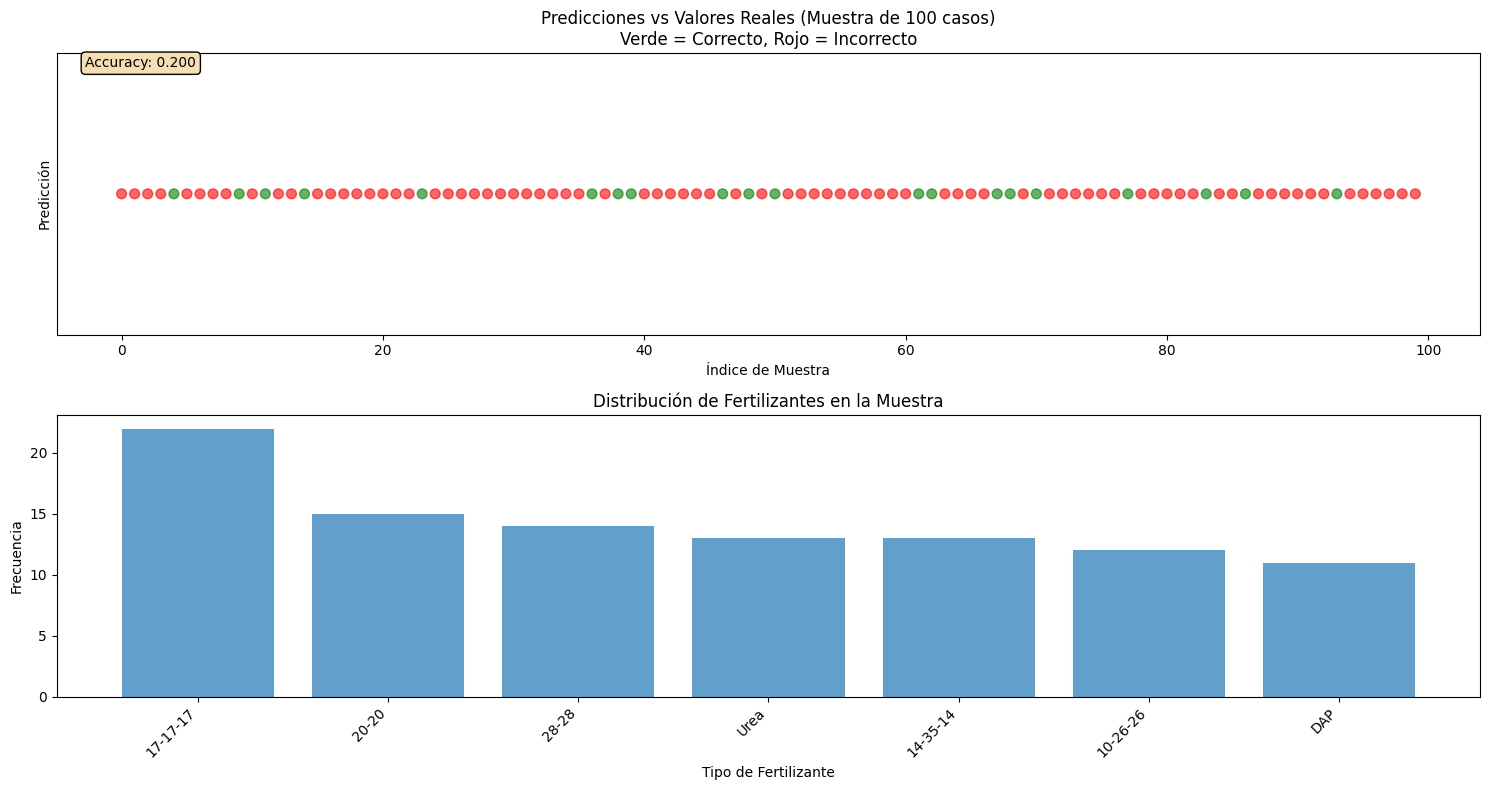

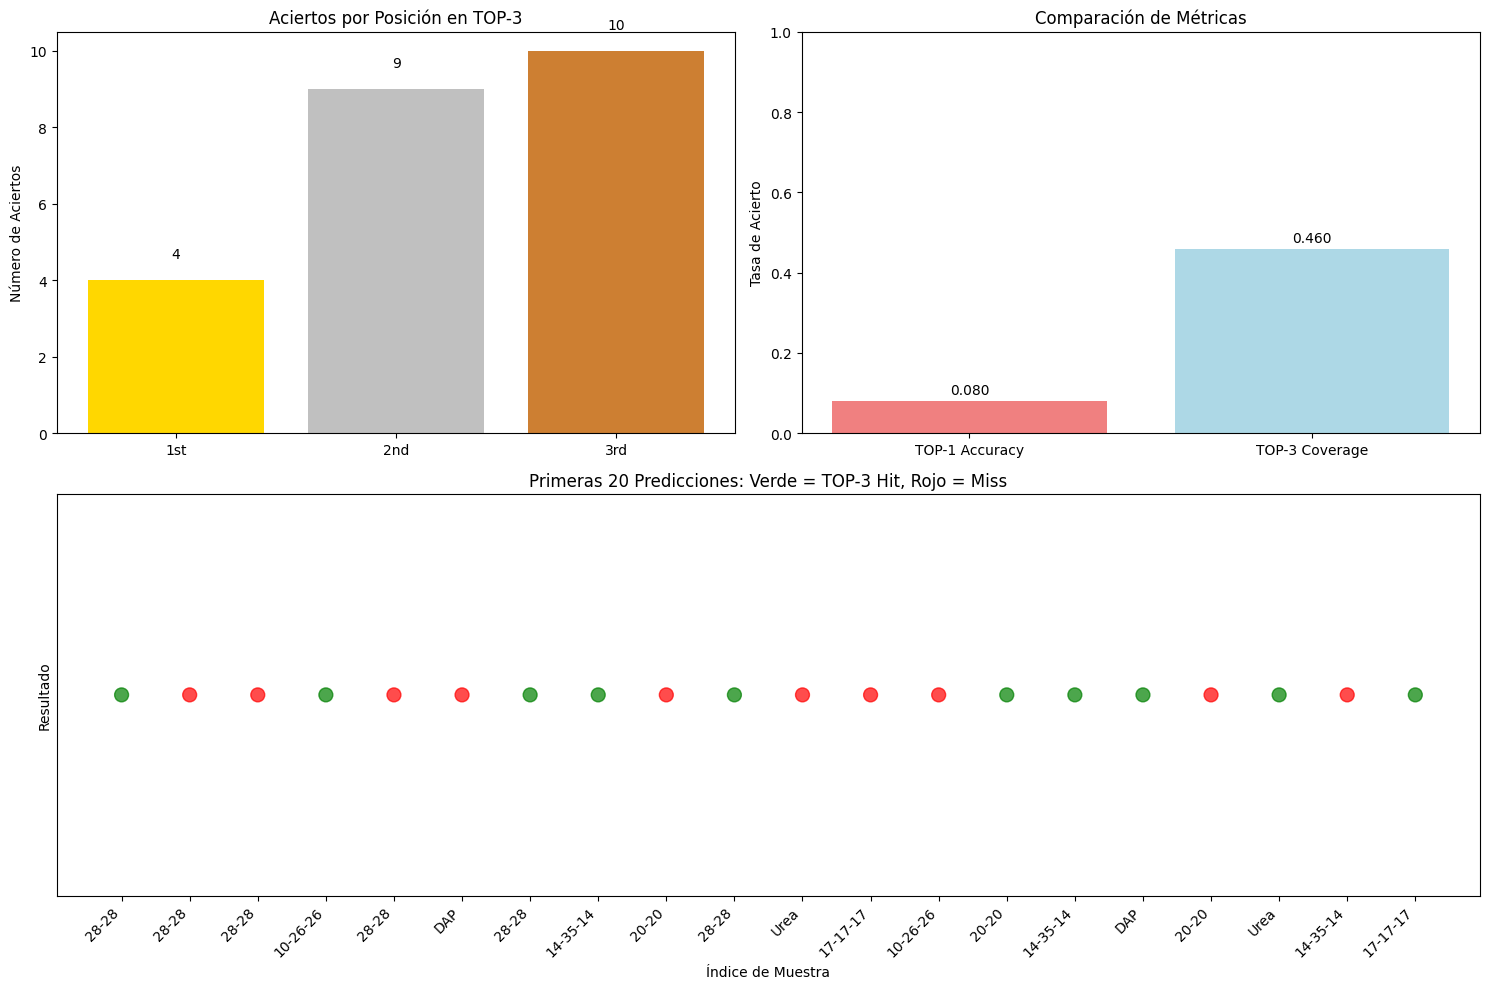


📊 Resumen TOP-3 Analysis:
  • Total samples: 50
  • TOP-3 Coverage: 0.460 (23/50)
  • Position 1 hits: 4 (0.080)
  • Position 2 hits: 9 (0.180)
  • Position 3 hits: 10 (0.200)
✅ Visualizaciones generadas correctamente


In [7]:
# =============================================================================
# VISUALIZACIONES DETALLADAS
# =============================================================================

# Importar funciones de visualización
import sys
sys.path.append('../src')
from visuals import (
    plot_confusion_matrix, 
    plot_probability_analysis, 
    plot_predictions_vs_actual,
    plot_top3_accuracy_analysis,
    plot_feature_importance
)

# 1. Matriz de confusión
fertilizer_names = [fertilizer_encoder.inverse_transform([c])[0] for c in classes]
plot_confusion_matrix(y_val, y_pred_val, fertilizer_names, "Matriz de Confusión - XGBoost")

# 2. Análisis de probabilidades
plot_probability_analysis(y_pred_proba_val, classes)

# 3. Comparación predicciones vs valores reales
comparison_df = plot_predictions_vs_actual(y_val, y_pred_val, fertilizer_encoder, sample_size=100)

# 4. Análisis detallado de TOP-3
top3_analysis = plot_top3_accuracy_analysis(y_val, y_pred_top3, fertilizer_encoder, sample_size=50)

print("✅ Visualizaciones generadas correctamente")

## 💾 6. Guardado del Modelo y Métricas

### Guardado del modelo entrenado y exportación de resultados

💾 Guardando artefactos en: XGB_MAP@3-03254/
✅ Artefactos guardados en carpeta: XGB_MAP@3-03254/
🏆 TOP 10 FEATURES MÁS IMPORTANTES:
 1. Dominant_NPK_Level             0.0449
 2. Phosphorous                    0.0445
 3. Nitrogen                       0.0438
 4. Moisture                       0.0437
 5. P_K_ratio                      0.0429
 6. Crop Type_encoded              0.0428
 7. N_P_ratio                      0.0428
 8. Potassium                      0.0428
 9. N_K_ratio                      0.0424
10. Temp_Moist_inter               0.0420


d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:247: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='importance', y='feature', ax=ax1, palette='viridis')
d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:261: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\gh\kaggle\kaggle-playground-series-s5e6\notebooks\../src\visuals.py:261: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Felix\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Felix\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:

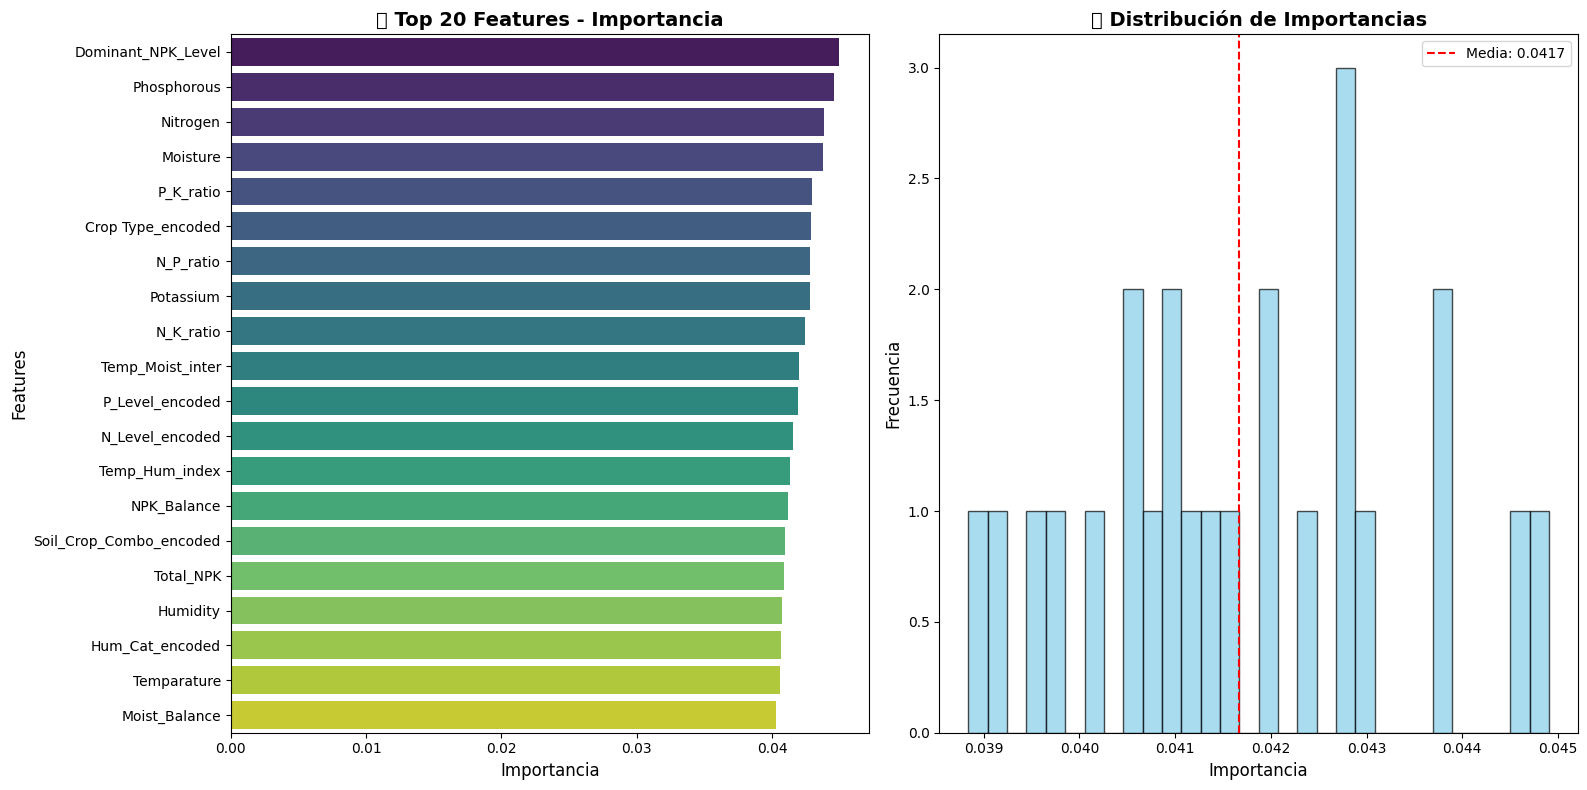


📈 Estadísticas de importancia:
  • Feature más importante: Dominant_NPK_Level (0.0449)
  • Importancia promedio: 0.0417
  • Importancia mediana: 0.0414
  • Features con importancia > promedio: 11
🔍 Feature importance: XGB_MAP@3-03254_feature_importance.csv

🎉 RESUMEN - XGBClassifier
🎯 MAP@3: 0.3254
📊 AUC-ROC: 0.5654
🎯 Features: 24
⏱️ Tiempo: 875.66s


In [8]:
# =============================================================================
# GUARDADO DEL MODELO Y ARTEFACTOS
# =============================================================================

# Guardar todos los artefactos con nomenclatura estandarizada
base_filename = trainer.save_model_artifacts(
    model=xgb_model,
    metrics=metrics, 
    hyperparams=xgb_params,
    features=features_to_use
)

# Guardar feature importance
feature_importance_df = plot_feature_importance(
    feature_importances=xgb_model.feature_importances_,
    feature_names=features_to_use,
    title="Importancia de Features - XGBoost TIER 1"
)

feature_importance_path = f'../models/{base_filename}/{base_filename}_feature_importance.csv'
feature_importance_df.to_csv(feature_importance_path, index=False)
print(f"🔍 Feature importance: {base_filename}_feature_importance.csv")

# Resumen final
trainer.print_summary(features_to_use)

## 📋 8. Generación de Submission (Opcional)

### Predicciones para el conjunto de test y creación del archivo de submission

In [9]:
# =============================================================================
# GENERACIÓN DE SUBMISSION PARA KAGGLE
# =============================================================================

# Generar submission usando el trainer
submission_df = trainer.generate_submission(
    X_test=X_test,
    features=features_to_use,
    label_encoder=fertilizer_encoder,
    base_filename=base_filename
)

# Mostrar muestra del submission
print(f"\n📋 SUBMISSION GENERADO:")
print(f"Formato: {list(submission_df.columns)} | Filas: {len(submission_df)}")

📤 Generando submission...
✅ Submission guardado en: XGB_MAP@3-03254/

📋 SUBMISSION GENERADO:
Formato: ['id', 'Fertilizer Name'] | Filas: 250000
